<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Text Generation Using LSTMs</center></font></h1>
<h1><center>Article Title Prediction</center></h1>
<h3><center>Charlcye Mitchell, April 2024</center></h3>

# **Text Generation using LSTMs**

## **Table of Contents**
------------------

- [Introduction](#intro)
- [Import libraries and packages](#ilp)
- [Dataset Information](#di)
- [Separate 'Title' field and preprocess it](#preprocess)
    - [Removing unwanted charaters and words](#remv)
    - [Tokenization and word_index (vocabulary) ](#token)
    - [Convert titles into sequences and make n_gram model](#ngram)
    - [Making all titles with same length and padding them](#pad)
- [Prepare features (X) and labels (Y)](#xy)
- [Architechture of the LSTM neural network](#lstm)
- [Train the LSTM neural network](#train)
- [Plotting the accuracy and loss graph](#acc)
- [Predict new title (Testing)](#new)

----------------




<a name="intro"></a>

# **Introduction**

Text Generation is the task of predicting what word comes next, given what words lied ahead of it. It can be thought of as a chain of Auto-Predict task, where we continuously produce the next word, from the current word. While dealing with text, we need to train our model to forget old Context, update new Context, with each new words in the sequence, as each new words received brings some value-addition to the Context. For example, Pronouns are changed when the person we are talking about changes in the sentence.

Therefore,we leverage LSTM Reccurent Neural Networks to perform Text Generation. LSTM has a Context vector, and it has Forget gate to decide which part of the Old Context it should forget, an Input Gate to decide which part of the Input brings what change in the context,and an Output Gate to produce the Output or the next Word in our Text Generation task.



<img src="https://miro.medium.com/max/1400/1*_MrDp6w3Xc-yLuCTbco0xw.png"></img>


Auto Text Generation is also called Natural Language Modelling, because training Machines to perform Text Generation is an attempt to teach Machines, the mappings between words, and how words in a particular language are related to one another. By learning, which words appear after a sequence of words, or after a significant volume of natural language, all encoded within a context vector, macines learn to replicate human understanding of Natural Language in a sense.

Here are some applications where Language Modelling comes into play.

**1) Mobile keyboard text recommendation**

<img src="https://img.gadgethacks.com/img/63/81/63566870205373/0/get-emoji-suggestions-with-any-android-keyboard.1280x600.jpg"></img>


**2) Whenever we search for something on any search engine, we get many suggestions and,  as we type new words in it, we get better recommendations according to our searching context. So, how does this happen?**

<img src="https://storage.googleapis.com/gweb-uniblog-publish-prod/original_images/sf_autocomplete_search.jpg"></img>



It is possible because of Natural Language Processing (NLP) techniques. Here, we will use NLP and try to make a prediction model using an LSTM (Long short-term memory) model that will predict the next words of a sentence.

<a name="ilp"></a>
# **Importing the necessary libraries**

In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

<a name="di"></a>
# **Dataset Information**

**Import Medium-articles-dataset:**

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 Digital Sources. Our assumption here is, by exposing our model to NaturalLanguage in a particular domain, it will see instances of which words usually occur in sequence and therefore on training, it will learn the mapping of which words are likely to occur given a particular context. :

- Towards Data Science
- UX Collective
- The Startup
- The Writing Cooperative
- Data Driven Investor
- Better Humans
- Better Marketing

Dataset link: https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset


### **Load the Dataset**

In [ ]:
data = pd.read_csv('/content/medium_data.csv')
data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [ ]:
print("Number of records: ", data.shape[0])
print("Number of fields: ", data.shape[1])

Number of records:  6508
Number of fields:  10


Here, we have **10 different fields and 6508 records** but we will only use the **title field** to predict the next word.

<a name="preprocess"></a>
# **Displaying the titles of various articles and preprocessing them**

In [ ]:
data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [ ]:
data['title'][1]

'Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric'

In [ ]:
data['title'][690]

'How to Write a Non-Fiction Book in 30\xa0Days'

<a name="remv"></a>
#### **Removing unwanted characters and words in titles**

Looking at the titles, we can see there are some unwanted characters and words, which may not be useful for us for prediction purposes - in fact these characters and words may decrease our model accuracy. Hence they have to be removed.

In [ ]:
data['title'] = data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
data['title'] = data['title'].apply(lambda x: x.replace('\u200a',' '))

In [ ]:
data['title'][690]

'How to Write a Non-Fiction Book in 30 Days'

<a name="token"></a>
#### **Tokenization**

Tokenization is the process by which we convert texts into separable units, i.e, words. But here, we are using a pre-built Tokenizer that converts each words to their One-hot encoding indexes, by providing a unique ID to all the words.

In [ ]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


<a name="ngram"></a>

### **Text into sequences and Generating n-gram Sequence for training**

NLP language models require sequential input data, and the input word/token must be numerical. Here we are generating n-grams in order to train our model for next word prediction.

Let's suppose we have a sentence such as **"I am good"** - this will convert into a sequence with their respective tokens **{'I' : 1, 'am' :  2, 'good' : 3}**.

Thus, the output would be:  **[ '1', '2', '3' ]**

Likewise, all our titles will be converted into sequences.

Then, we will make an n_gram model for good predictions.

The image below explains this process.
<img src="https://i.postimg.cc/K8gZsxjy/ngram.png"></img>

Since we are training our model on Sequential Text Generation, what we are doing here is essentially increasing the total number of training examples, as if "I am a Data Scientist" is an example text, then so is "I am a".

In [ ]:
input_sequences = []
for line in data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Streaming output truncated to the last 5000 lines.
[1541, 3, 2944, 818, 5, 21]
[4740, 90, 99, 236]
[30, 46, 864, 232, 217, 6, 284]
[113, 4741, 2945, 59, 1246, 5, 4742, 4743, 83, 172]
[80, 13, 32, 119, 25, 70, 44, 366, 5, 36, 178]
[47, 54, 560, 2, 736, 1872, 1247]
[49, 3, 87, 7, 2, 66, 1748, 9, 12, 105, 5, 34, 244]
[93, 13, 30, 5, 134, 193, 178, 13, 32, 971, 2946, 1749]
[466, 1750, 9, 36, 34, 819, 5, 34, 244]
[175, 34, 308, 34, 9, 303, 596]
[22, 13, 51, 9, 10, 34, 840, 795, 2947]
[3, 885, 811, 6, 115, 2880]
[3, 97, 102, 4744, 2, 4745, 15, 140, 183, 31, 539, 60, 299, 520]
[126, 168, 4746, 494, 4747, 8, 4748, 1454]
[3, 513, 6, 1287, 15, 4749]
[108, 17, 425, 9, 1319, 8, 109, 1018]
[2948, 282]
[22, 117, 291, 2696, 286, 187, 37, 117, 1060, 1248]
[22, 30, 3, 113, 1030, 56, 112, 245]
[3, 4750, 2949, 6, 101, 1152]
[3, 370, 2, 300, 5, 272, 42]
[4, 19, 11, 4, 11, 20, 4, 2, 3, 115, 4751, 776, 1455, 2, 4752, 5, 123, 4753, 4]
[124, 2, 4754, 25, 592, 2, 5, 123, 56]
[5, 4755, 2950, 23, 314, 139, 185, 

<a name="pad"></a>
### **Make all titles the same length through padding**

The length of every title has to be the same - using padding we make every sequence have the same length. To do this, we need to find a title that has a maximum length, and based on that length, we have to pad the rest of the titles.

- **max_sequence_len**: is the sequence length.
- **pad_sequences**: provided by Keras is used to pad an array of tokens to a given length.

In [ ]:
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

In [ ]:
input_sequences.shape

(48461, 40)

In [ ]:
input_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,
       676], dtype=int32)

<a name="xy"></a>
## **Preparing Predictors and Labels**

Here, we consider the **last element of all the sequences as a label**.

We need to perform **one-hot encoding on labels corresponding to total_words.**

In [ ]:
# Create features and label
predictors, target = input_sequences[:,:-1],input_sequences[:,-1]
labels = tf.keras.utils.to_categorical(target, num_classes=total_words)

- predictors : these are tokens that will be used as an input for predicting the next word.
- label: is the next word to be predicted.

In [ ]:
#inputs i.e, predictors
predictors[3]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,  68,   2],
      dtype=int32)

In [ ]:
print(labels[5][14])

1.0


<a name="lstm"></a>
## **Architecture of the LSTM Neural Network**

Long Short-Term Memory networks (LSTMs) are advanced Recurrent Neural Networks (RNNs), capable of storing order states through their cell state feature.

<img src="https://www.researchgate.net/profile/Xuan_Hien_Le2/publication/334268507/figure/fig8/AS:788364231987201@1564972088814/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan.png"></img>

<a name="train"></a>
## **LSTM Neural Network Model Training**

In [ ]:
model = Sequential()

inp_len = max_sequence_len - 1

# Adding Input Embedding Layer
model.add(Embedding(total_words, 100, input_length = inp_len))

# Adding Hidden Layer 1 - LSTM Layer
model.add(LSTM(150,return_sequences=True))

model.add(LSTM(100,activation='relu'))


# Adding Output Layer
model.add(Dense(total_words, activation = 'softmax'))

opt = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 100)           823800    
                                                                 
 lstm_2 (LSTM)               (None, 39, 150)           150600    
                                                                 
 lstm_3 (LSTM)               (None, 100)               100400    
                                                                 
 dense_1 (Dense)             (None, 8238)              832038    
                                                                 
Total params: 1906838 (7.27 MB)
Trainable params: 1906838 (7.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mcp_save = ModelCheckpoint('.mdl_wts.h5', save_best_only=True, monitor='loss', mode='min')

In [ ]:
history = model.fit(predictors, labels, epochs = 15, callbacks=[es,mcp_save], verbose = 1)

Epoch 1/15
1515/1515 [==============================] - 119s 78ms/step - loss: 1.7826 - accuracy: 0.5917
Epoch 2/15
1515/1515 [==============================] - 116s 77ms/step - loss: 1.6614 - accuracy: 0.6125
Epoch 3/15
1515/1515 [==============================] - 115s 76ms/step - loss: 1.5460 - accuracy: 0.6388
Epoch 4/15
1515/1515 [==============================] - 117s 77ms/step - loss: 1.4413 - accuracy: 0.6607
Epoch 5/15
1515/1515 [==============================] - 115s 76ms/step - loss: 1.3613 - accuracy: 0.6792
Epoch 6/15
1515/1515 [==============================] - 116s 77ms/step - loss: 1.2841 - accuracy: 0.6955
Epoch 7/15
1515/1515 [==============================] - 116s 77ms/step - loss: 1.2191 - accuracy: 0.7103
Epoch 8/15
1515/1515 [==============================] - 118s 78ms/step - loss: 1.1558 - accuracy: 0.7247
Epoch 9/15
1515/1515 [==============================] - 114s 75ms/step - loss: 1.1026 - accuracy: 0.7376
Epoch 10/15
1515/1515 [==============================] 

<a name="acc"></a>

## **Plotting the model accuracy and loss**

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

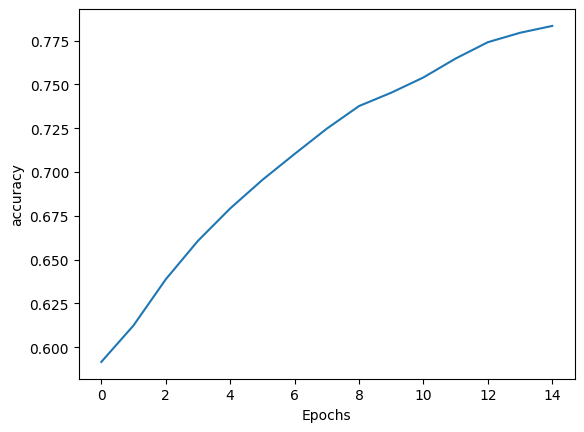

In [ ]:
plot_graphs(history, 'accuracy')

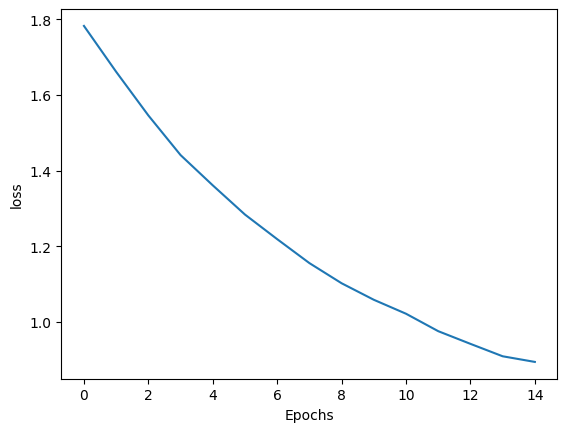

In [ ]:
plot_graphs(history, 'loss')

<a name="new"></a>
## **Text Generation (Prediction)**

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        token_list = pad_sequences([token_list], maxlen = max_sequence_len - 1, padding='pre')

        predicted = model.predict(token_list, verbose=0)

        classes_x = np.argmax(predicted,axis=1)

        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == classes_x:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

- **seed_text**: the initial words that will be passed for text generation.
- **predict_classes**: it will return the token id for the predicted word.
- **predicted**: It's the token id for a predicted word and this will be converted back into a word using the - dictionary **tokenizer.word_index .items()**.
- **next_words**: It’s the number of next words we want to be predicted.

## **Generation of Text Using Initial Text or "seed_text" and Maximum Sequence Length"**

In [ ]:
print (generate_text("implementation of ", 2, model, max_sequence_len))
print (generate_text("implementation of ", 4, model, max_sequence_len))

Implementation Of  Rnn Lstm
Implementation Of  Rnn Lstm And Gru


In [ ]:
print (generate_text("How to use", 5, model, max_sequence_len))

How To Use Pandas To Analyze Numeric Data


In [ ]:
print (generate_text("Forecasting ", 7, model, max_sequence_len))

Forecasting  User Experience And Agile Here Today The


In [ ]:
print (generate_text("Data", 3, model, max_sequence_len))

Data Science Productionization Scale


In [ ]:
print (generate_text("Deep Learning is a ", 1, model, max_sequence_len))

Deep Learning Is A  Real


In [ ]:
print (generate_text("Machine Learning", 8, model, max_sequence_len))

Machine Learning For Data Analysts — Bigquery Ml Use Classification


### **Observation**
As we can see, all text generated by our Model is basically replicating how humans would type out a Headline. That means, our model has learned how to generate text like the data it was trained on.

### **Saving the Model as a Pickle file**

In [ ]:
model.save("text_generator.h5")